## D213 Advanced Data Analytics PA 1
##### Submitted By Edwin Perry
### Table of Contents
<ol>
    <li><a href="#A">Research Question</a></li>
    <li><a href="#B">Data Preparation</a></li>
    <li><a href="#C">Network Architecture</a></li>
    <li><a href="#D">Model Evaluation</a></li>
    <li><a href="#E">Summary and Recommendations</a></li>
    <li><a href="#F">Reporting</a></li>
</ol>
<h4 id="A">Research Question</h4>
<h5>Providing Question</h5>
<p>For this project, I want to determine if a neural network trained on customer reviews is adequate at predicting overall customer sentiment</p>
<h5>Objectives/Goal</h5>
<p>The overall goal of this process is to create a neural network capable of accurately predicting the customer rating of transactions and services based on the textual review the customer has left

The use of a neural network to recognize positive or negative user sentiment about a movie based on textual review is a relatively complex natural language processing (NLP) technique. The used dataset will include a binary decision as to whether or not the customer enjoyed the movie, which can be used as a "truth" or "false" value, allowing me to test the model predictions against the actual values.

The neural network created from this process could be used for a number of future uses. Perhaps the most useful that I can think of is fake review detection. Multiple products and services are known to suffer from fake reviews submitted by bots, rather than reviews from people that have actually watched the movie. 
This neural network can identify those reviews that do not align the textual review with the provided rating, helping to root out the most likely fake reviews.</p>
<h5>Type of Neural Network</h5>
<p>Neural networks come in a variety of types, and as such, it is important to identify the ideal type to use for this particular analysis. The type that I decided to use for this analysis is a Recurrent Neural Network (RNN). I decided to use this type because, rather than analyzing the data in the text review in a manner whereby it is simply checking the value of words, it instead takes into account the word order as well. For example, if a user were to say "I do not recommend this movie," most other models would consider each word independently from each other, and would likely conclude that the rating would be positive. The RNN, however, can take into account the combination of the words "not" and "recommend" being sequential, recognizing that the user has a negative review.</p>
<h4 id="B">Data Preparation</h4>
<p> There are a few tasks that neeed to be performed before the neural network can be created and tested, including performing some exploratory data analysis. The first thing that we will do is import the required libraries/packages and load the data into the Jupyter Notebook</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Embedding, Flatten
from tensorflow.keras.models import Sequential
import nltk
import string
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
pd.set_option("display.max_columns", None)

2025-02-15 14:00:25.852923: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-15 14:00:25.855781: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-15 14:00:25.862393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739646025.872961   20829 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739646025.876007   20829 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-15 14:00:25.888742: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
import os
# Initialize a dictionary to store the data
data_dict = {}
# Define the folder path
folder_path = './sentiment+labelled+sentences'
full_folder_path = './sentiment+labelled+sentences/sentiment labelled sentences'

# List all files in the folder
files = [f for f in os.listdir(full_folder_path) if f != 'readme.txt']

# Initialize a dictionary to store file lengths
file_lengths = {}
print(files)
# Read each file and calculate its length
for file in files:
    with open(os.path.join(full_folder_path, file), 'r', encoding="utf-8") as f:
        content = f.readlines()
        for line in content:
            text = line[0:-2]
            label = line[-2]
            data_dict[text.strip()] = int(label)
            file_lengths[file] = len(content)
        

# Print the lengths of each file
for file, length in file_lengths.items():
    print(f"{file}: {length} lines")


['amazon_cells_labelled.txt', 'imdb_labelled.txt', 'yelp_labelled.txt']
amazon_cells_labelled.txt: 1000 lines
imdb_labelled.txt: 1000 lines
yelp_labelled.txt: 1000 lines


<p>Above, we can notice that we have 1000 lines in each file, giving us access to 3000 rows of data total. Next, we will look into the presence of unusual characters within the data</p>

In [3]:
import re

# Define a function to check for non-English characters
def contains_unusual_characters(text):
    # Define a regex pattern to match non-English characters and emojis
    pattern = re.compile(r'[^\x00-\x7F]+')
    return bool(pattern.search(text))

# Initialize a list to store keys with unusual characters
unusual_keys = []

# Iterate through the keys in data_dict and check for unusual characters
for key in data_dict.keys():
    if contains_unusual_characters(key):
        unusual_keys.append(key)

# Print the keys with unusual characters
print("Keys with unusual characters:")
for key in unusual_keys:
    print(key)
print(len(unusual_keys))

Keys with unusual characters:
It's practically perfect in all of them  a true masterpiece in a sea of faux "masterpieces.
I'm glad this pretentious piece of s*** didn't do as planned by the Dodge stratus Big Shots... It's gonna help movie makers who aren't in the very restrained "movie business" of Québec.
The script iswas there a script?
I'll even say it again  this is torture.
This show is made for Americans - it is too stupid and full with hatred and clichés to be admitted elsewhere.
A cheap and cheerless heist movie with poor characterisation, lots of underbite style stoic emoting (think Chow Yun Fat in A Better Tomorrow) and some cheesy clichés thrown into an abandoned factory ready for a few poorly executed flying judo rolls a la John Woo.
And I forgot: The Casting here i superb, with Trond Fausa Aurvåg being perfect in the role as the Bothersome Man, who doesn't understand where he is, what he is doing and why.
The script is bad, very bad  it contains both cheesiness and une

<p>Obviously, we can see that only 17 rows contain these unusual characters. Due to the incredibly small number of unusual keys, I believe that filtering them from our analysis is justified.</p>

In [4]:
# Filter out keys that are present in unusual_keys
filtered_data_dict = {key: value for key, value in data_dict.items() if key not in unusual_keys}

# Print the length of the filtered dictionary to verify
print(f"Original data_dict length: {len(data_dict)}")
print(f"Filtered data_dict length: {len(filtered_data_dict)}")

Original data_dict length: 2982
Filtered data_dict length: 2965


Now that these filtered values are removed, we will proceed to determine the vocabulary size of the reviewers in the dataset

In [5]:
from collections import Counter
import nltk
# Ensure 'punkt' is downloaded
nltk.download('punkt')
nltk.download('punkt_tab')

# Tokenize the text in the keys of filtered_data_dict
all_words = []
for review in filtered_data_dict.keys():
    tokens = nltk.word_tokenize(review)
    all_words.extend(tokens)

# Count the unique words
vocabulary_size = len(set(all_words))

print(f"Vocabulary size: {vocabulary_size}")

Vocabulary size: 6012


[nltk_data] Downloading package punkt to /home/edwinp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/edwinp/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Next, we will propose a word embedding length. This will be determined using the logarithm of the vocabulary size, to ensure that the dataset is not filtered such that it is too small to notice critical information, but that we are filtering out enough data to avoid unnecessary computational complexity.

In [6]:
import math

# Calculate the proposed embedding length
proposed_embedding_length = math.ceil(math.log2(vocabulary_size))
print(f"Proposed embedding length: {proposed_embedding_length}")

Proposed embedding length: 13


Finally, we will determine the maximum sequence length for this analysis. This will be done by determining the 95th percentile of review lengths, and using that value as the maximum sequence length. This will allow the reviews to have a length-constraint that optimizes model performance by filtering out excessively long reviews while also retaining the vast majority of reviews.

In [7]:
# Calculate the lengths of the reviews
review_lengths = [len(nltk.word_tokenize(review)) for review in filtered_data_dict.keys()]

# Calculate the 95th percentile of review lengths
max_sequence_length = np.percentile(review_lengths, 95)
max_sequence_length = int(max_sequence_length)
print(f"Statistically justified maximum sequence length: {max_sequence_length}")

Statistically justified maximum sequence length: 30


<h5>Goals of Tokenization Process</h5>
<p>The next step in the data preparation is tokenizing the text reviews. Neural networks cannot inherently interpret raw text, so we need to break the text into smaller units that map to numeric values.</p>

In [8]:
# Initialize the tokenizer
tokenizer = Tokenizer(num_words=vocabulary_size, oov_token="<OOV>")
tokenizer.fit_on_texts(filtered_data_dict.keys())

# Convert the text to sequences
sequences = tokenizer.texts_to_sequences(filtered_data_dict.keys())

# Convert the labels to a numpy array
labels = np.array(list(filtered_data_dict.values()))
print(f"Labels shape: {labels.shape}")

Labels shape: (2965,)


<h5>Padding Process Explanation</h5>
<p>Padding is an essential process in the preparation of this data for the neural network. It is designed to standardize the size of the inputs, which inherently have different lengths. I am going to add the padding to the end of the sequence, using the padding='post' argument.</p>

In [9]:
# Pad the sequences to ensure they all have the same length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

print(f"Padded sequences shape: {padded_sequences.shape}")

Padded sequences shape: (2965, 30)


<p>Below, we see one example of a padded sequence. The several entries of 0 at the end indicate padded values</p>

In [10]:
# Print a single padded sequence
print(padded_sequences[0])

[  28   47    6   57  117   13   71    8  370    7   12   66   12    2
  185  578    4   76   61    5 2243    0    0    0    0    0    0    0
    0    0]


<h5>Sentiment Categories</h5>
<p>There will only be 2 categories of sentiment used in this analysis, as we only have positive and negative reviews for this data, meaning that we have binary classification. The activation function will similarly be sigmoid, which will allow us to determine the positive or negative value based on whether the calculated value meets a certain threshold</p>
<h5>Steps Explanation</h5>
<p>To review the steps of the data preparation, we started, after importing the data, with filtering out any reviews that contained characters that couldn't be interpreted. Then, we determined the vocabulary size, proposed a word embedding length, and calculated a statistically-justified maximum sequence length. Then, we tokenized the reviews to convert the textual, unusable data into numerical data that could be used by the neural network. The next step was to pad the data, to ensure that the inputs were of a standard length. Now, we will split the data into training, validation, and testing sets. An 80%/10%/10% split is most common in a neural network. The training set, of course, requires the majority of the data, to train it in the widest variety of information possible and ensure the best performance. A 10% validation set is technically optional, but it is ideal. The validation set is useful in detecting overfitting and can fine-tine hyperparameters, improving the performance of the model. Finally, we use a 10% test set, to evaluate the performance of the model.

In [11]:
# Split the data into training and temporary datasets
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42)

# Split the temporary dataset into validation and test datasets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training data shape: (2075, 30)
Validation data shape: (445, 30)
Testing data shape: (445, 30)
Training labels shape: (2075,)
Validation labels shape: (445,)
Testing labels shape: (445,)


In [12]:
# Convert the numpy arrays to pandas DataFrames
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)
y_train_df = pd.DataFrame(y_train, columns=['label'])
y_test_df = pd.DataFrame(y_test, columns=['label'])
y_validation_df = pd.DataFrame(y_train, columns=['label'])
X_validation_df = pd.DataFrame(y_test, columns=['label'])

# Save the DataFrames to CSV files
X_train_df.to_csv('X_train.csv', index=False)
X_test_df.to_csv('X_test.csv', index=False)
y_train_df.to_csv('y_train.csv', index=False)
y_test_df.to_csv('y_test.csv', index=False)
X_validation_df.to_csv('X_validation.csv', index=False)
y_validation_df.to_csv('y_validation.csv', index=False)

<h4 id="C">Network Architecture</h4>
<h5>Output of the Model Summary</h5>

In [13]:

from tensorflow.keras.layers import LSTM, Dropout

# Define model
model = Sequential([
    Embedding(input_dim=vocabulary_size, output_dim=proposed_embedding_length, input_length=max_sequence_length),  # Word embedding
    LSTM(64, return_sequences=False),  # LSTM layer for sequential processing
    Dropout(0.5),  # Prevents overfitting
    Dense(32, activation='relu'),  # Fully connected layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop_check = EarlyStopping(monitor= 'val_accuracy', patience=3)
results = model.fit(X_train, y_train, validation_data= (X_val, y_val), epochs=15, callbacks=early_stop_check)
# Summary
model.summary()

Epoch 1/15


/home/edwinp/.local/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-02-15 14:00:27.495849: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4867 - loss: 0.6937 - val_accuracy: 0.5303 - val_loss: 0.6924
Epoch 2/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4981 - loss: 0.6934 - val_accuracy: 0.4652 - val_loss: 0.6939
Epoch 3/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5173 - loss: 0.6897 - val_accuracy: 0.7079 - val_loss: 0.5879
Epoch 4/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8189 - loss: 0.4265 - val_accuracy: 0.8202 - val_loss: 0.4321
Epoch 5/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9274 - loss: 0.2219 - val_accuracy: 0.8202 - val_loss: 0.4334
Epoch 6/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9647 - loss: 0.1225 - val_accuracy: 0.8022 - val_loss: 0.7958
Epoch 7/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9775 - loss: 0.0751 - val_accuracy: 0.7978 - val_loss: 0.8034


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 30, 13)         │        78,156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 300,713 (1.15 MB)

 Trainable params: 100,237 (391.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 200,476 (783.11 KB)

<h5>Layer and Parameter Explanation</h5>
<p>This is a sequential model consisting of 5 Layers. <br />
The first layer in the model in an embdedding layer. This will convert the words into numerical vectors in a manner similar to one-hot encoding, but in a more efficient manner. This layer also learns the relationships that words have with each other. This layer consists of the highest number of parameters, which is derived from multiplying the vocabulary size vs the vector length for each word (6012 * 13).<br />
The next layer that is used is the LSTM layer. This layer is necessary to capture sequential patterns in the text. Without this layer, the model would not be able to consider how words influence each other, so if a user were to type "not good" in a review without this layer, each word would be analyzed independently. With this layer, the model is capable of understanding that the word "good" is negated by the word "not." This layer has a mathematical formula to determine the number of parameters. If we were to say the number of neurons (64) is x and the input size from the embedding layer (13) was y, the mathematical formula would be: Parameters = 4 * ((x * (x + y)) + y).<br />
The third layer is the dropout layer. This layer can be thought of as "turning off" 50% of the model's neurons during training. This helps the model focus on generalizing observations, rather than overfitting. This will help ensure that the model is reliable when analyzing unseen reviews. This layer has no parameters, as it exists solely to reduce the model overfitting.<br />
Next, we have our dense layer. This layer is essential due to the compressed output that the LSTM layer provides. The dense layer takes this data and transforms it such that it can be effectively used for binary classification. This layer consists of 32 nodes and the number of parameters is determined by multiplying the nodes of this layer (32) plus one (33) against the nodes of the previous layer (64), which results in 2080 parameters. <br />
Finally, we have our output layer. This layer reduces the data to a probability score between 0 and 1 for the sentiment classification. This layer only requires a single neuron, and if that neuron has an output of 0.5 or higher, we consider the sentiment to be positive. Otherwise, it considers the sentiment to be negative. This layer has 33 parameters, which is the input from the prior layer (32) plus an additional round of output.</p>
<h5>Choice of Hyperparameters</h5>
<p>Hyperparameters are very important to use correctly in any neural network.<br />
Throughout the analysis, 2 activation functions were used, once each: Rectified Linear Unit (ReLU) and Sigmoid. ReLU's high performance has made it an industry standard, and is often considered the defauly activation function for the dense layer. The output layer used a sigmoid function, to ensure that the model could be classigied in a binary manner. The sigmoid function's maximum and minimum values are 1 and 0, meaning that the data point could be classified based on whether the value was determined to be closer to the maximum or minimum.<br />
The nodes are also important to determine in each layer. The nodes in the embedding layer are meant to be equal to the proposed embedding length that we have already established earlier in our analysis. 64 nodes were used on the LSTM layer because of the small size of the dataset. Using any more nodes would likely cause overfitting and harm performance going forward, given that the dataset only contains 3000 rows. The dropout layer doesn't exectly consider nodes the way the other layers do, and so it can be considered to have 0 nodes. Because the data is very simple, few nodes are required in the dense layer. As such, we have reduced the number of nodes from 64 to 32, to prevent overfitting of the data. Finally, we have the output step. Only 1 node is required, as we are trying to perform a sigmoid analysis with only one decision to be made: 1 or 0. This binary classification is best done with only one node to classify the data.<br />
The loss function used in this analysis was binary cross-entropy. The model is attempting to solve a classification problem, rather than performing regression. This means that we need binary solutions (values of 1 or 0) for each input considered, which will be entirely correct or incorrect. Therefore, we need a binary loss function that can accurately classify this data, which binary cross-entropy is capable of. <br />
The optimizer used for this analysis is Adam. This is a very commonly used, industry standard oprimizer that performs generally, and as no issues have arisen from using it within this context, there is no justification to deviate from the norm in this model. <br />
The stopping criteria for this model is going to be the validation accuracy of the model. As mentioned above, the validation data is meant to perform a type of test on the data before the actual test dataset to ensure that the data does not overfit. Using the accuracy of the validation data allows the model to be optimized to accurately classify a general dataset, preventing the model from biasing itself on the results of the training dataset. Furthermore, I am using accuracy over loss because the loss is a continuous value that does not necessarily translate to better performance, given that we are trying to classify in a binary way, rather than perform any sort of continuous analysis<br />
Finally, we have the evaluation metric. I determined that accuracy was the ideal metric to evaluate the performance of this model, for a variety of reasons. One reason is that accuract is a very intuitive, easy to interpret metric, which will allow the model's reliability to be understood much more simply. Furthermore, we have a balanced dataset, with no class imbalance in this project, which means there is no need to switch from accuracy, which is often the default in these types of analysis. Finally, accuracy is an incredibly efficient metric to calculate, as it doesn't need to take into account in which direction the data was wrong or how far off numerically the expected and true values are.</p>
<h4 id="D">Model Evaluation</h4>
<h5>Impact of Stopping Criteria</h5>
<p>We can see above that the model only continues training the data until epoch 11. This is because the maximal value for validation accuracy is achieved at epoch 8, with an 82% validation accuract rating. As the model was continually worsening the performance as it continued through the epochs, the model recognized that the performance had reached the maximal accuracy and ended early. Had the accuracy not continued this decline, the training process would have continued until one fo two conditions were met: either the model would have reached the maximum number of iterations, at 15, or it would have continued until there were 3 rows that performed worse than previous values, at which point it would have stopped.</p>


<h5>Assessing Fitness of Model</h5>
<p>Now that the model is created and trained, it is time to evaluate the performance of the model on the test data</p>

In [16]:
model.evaluate(X_test, y_test)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8054 - loss: 0.9800 


[0.8768873810768127, 0.802247166633606]

<p>We can see that the model has a reasonable degree of accuracy, predicting the values correctly 80.54% of the time. As such, we know that the model peformed well on the binary classification aspect of the analysis. However, a loss of 0.98 is remarkably high, and makes concerned about the model's performance going forward. I suspect that this might, at least in part, be a result of the remarkably small sample size that was used in this analysis. We started with only 3000 rows of data, and after splitting into training, testing, and validation sets, the data used to perform each task is tragically limited.
There were 2 actions that I took to help prevent overfitting. The first was the use of the Dropout layer in the model, to reduce the number of neurons by half. Reducing the number of neurons so drastically ensures that the model does not provide too much significance to the previous observations, reducing overfitting and improving the generalizability of the model. The next step I took was the use of the EarlyStopping() function. This function uses the validation dataset to determine implement a stop condition with the model, prioritizing accuracy on data that the model has not been trained with.</p>
<h5>Training Visualizations</h5>  

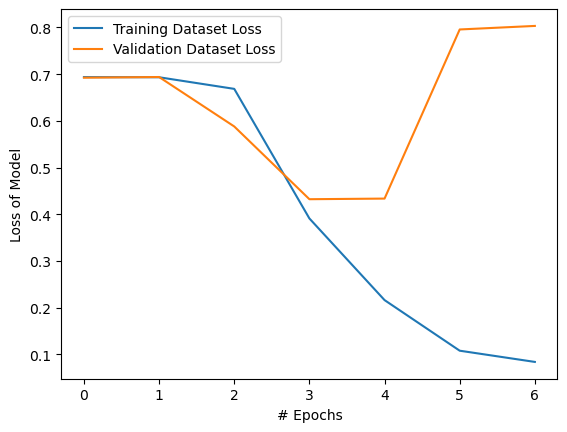

In [14]:
plt.plot(results.history['loss'], label= "Training Dataset Loss")
plt.plot(results.history['val_loss'], label= "Validation Dataset Loss")
plt.xlabel("# Epochs")
plt.ylabel("Loss of Model")
plt.legend()
plt.show()

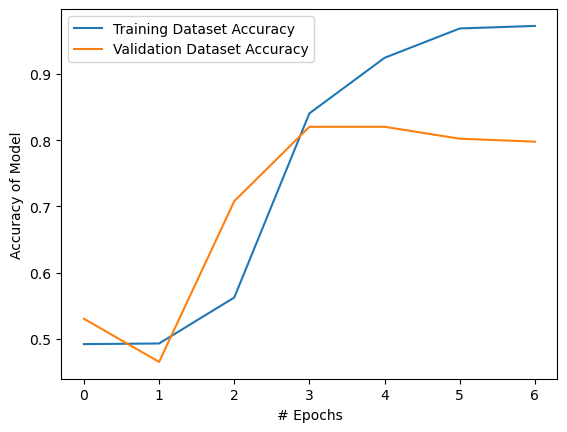

In [15]:
plt.plot(results.history['accuracy'], label= "Training Dataset Accuracy")
plt.plot(results.history['val_accuracy'], label= "Validation Dataset Accuracy")
plt.xlabel("# Epochs")
plt.ylabel("Accuracy of Model")
plt.legend()
plt.show()

<h5>Predictive Accruacy</h5>
<p>The final step in evaluating our model is to evaluate the accuracy of the model on the test data. We have already done so above, but here, we will look deeper into the data.</p>

In [ ]:
model.evaluate(X_test, y_test)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8054 - loss: 0.9800 


[0.8768873810768127, 0.802247166633606]

In [18]:
y_pred = model.predict(X_test)
# Round the probabilities provided by the model to the nearest integer
y_pred = np.rint(y_pred)
# Generate confusion matrix from the predictions and the y_test (truth) data
print(" Predicted Negative   |   Predicted Positive")
conf_mat = confusion_matrix(y_test, y_pred)
print(f"      {conf_mat[0]}     Real Negative           ")
print(f"     {conf_mat[1]}     Real Positive           ")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 Predicted Negative   |   Predicted Positive
      [193  45]     Real Negative           
     [ 43 164]     Real Positive           


<p>We can see that we have 357 correctly predicted values in this model, significantly more than the 88 false values. We can also validate that the likelihood of false negative and false positive is approximately equal, indicating that the model is not biased to provide any particular classification. The overall accuracy of the model makes it usable, with a decent degree of accuracy, but it is certainly far from infallable or certain in any given judgement.</p>
<h4 id="E">Code</h4>
<p>All of the code used to make this model is provided above. I am also going to save the model and submit it alongside this Jupyter Notebook</p>

In [19]:
model.save("D213P2Model.h5")

<h4 id="F">Functionality</h4>
<p>Overall, the model is fairly functional, capable of identifying customer sentiment approximately 80% of the time. However, the loss is significantly higher than I would prefer, indicating that the model is not necessarily confident in the predictions. Therefore, it is certain that, though the model is usable, there is potentially an opportunity to improve how the model functions</p> <br />
<p>The network architecture consists of 5 layers, which is fairly standard in smaller-scale neural networks such as this one. The layers work to first convert the model into a usable, numerical format (the embedded layer). Then, the LSTM layer is used to allow the model to capture sequential patterns in the text and solve for word dependencies. I also attempted to test this model with an additional Dense layer instead, but the accuracy was significantly harmed in my attempt to do so. The next layer used was the dropout layer, which was used to reduce the likelihood that the model suffers from overfitting (alongside the EarlyStopping function). This layer helped to ensure that the model wasn't overly focused on the training data and could instead make general predictions. Finally, we have the 2 Dense layers, the first transforming the data into a usable and efficient format, and the second (the output layer) using the sigmoid function to produce a probability score for binary classification. All of these layers were required to achieve this level of accuracy</p>
<h4 id="G">Course of Action</h4>
<p>Overall, this model has a decent degree of accuracy, but a very poor performance on the loss metric. As such, I think that using the model for wider usage is feasible, but the ideal option would be to access more data that would allow the model to be trained more in-depth, giving the model more confidence in the predictions, and hopefully improving both the loss and accuracy going forward. The model can be put to use in a variety of functions, but I would only recommend usage when there is a human that can parse through the results, to ensure valid results. For example, I mentioned in the goals section of this paper that the model could be used to identify fake reviews. With this model's performance, I would recommend using the model to parse through the reviews and identify those that return a false negative or false positive value. Then, a human could parse through the data manually to attempt to evaluate this much smaller dataset to determine if the reviews are falsified.</p>
<h4>Code References</h4>
<p><a href="https://app.datacamp.com/learn/custom-tracks/custom-advanced-data-analytics">DataCamp Track</a> used to learn how to use tensorflow and build the model</p>
<p><a href="https://www.tensorflow.org/text/tutorials/text_classification_rnn">Official Tensorflow Documentation</a> to create the RNN model</p>
<h4>Source References</h4>
<p><a href="https://www.geeksforgeeks.org/sentiment-analysis-with-an-recurrent-neural-networks-rnn/">Geeks For Geeks article</a> used to determine the ideal type of neural network for this analysis</p>
<p><a href="https://app.datacamp.com/learn/custom-tracks/custom-advanced-data-analytics">DataCamp Track</a> used to learn the conceptual information regarding neural network operation</p>